In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

from IPython.display import display

In [86]:
NUM_STATES = 4
NUM_OBSERVATIONS = 2
NUM_BELIEFS = 2 # TARGET vs. NON TARGET
ANGLE_RANGE = 2*np.pi

STATE_STEP = ANGLE_RANGE/NUM_STATES
STATE_CENTERS = np.arange(0, ANGLE_RANGE, STATE_STEP) + STATE_STEP
ANGL_DIST_BETWEEN_STATES = (STATE_CENTERS[np.newaxis, :] - STATE_CENTERS[:, np.newaxis])

PRIOR_TARGET_PROB = np.array([1/NUM_BELIEFS, 1-(1/NUM_BELIEFS)])
PRIOR_STATE_PROB = np.full(NUM_STATES, 1/NUM_STATES)
LIKELIHOOD_OBS_FROM_NONTARGET = 1/NUM_OBSERVATIONS

In [87]:
STATE_STEP

1.5707963267948966

In [88]:
def get_state_transition_matrix(candidate_step):
    if candidate_step>0:
        mod_basis = 2*np.pi
    else:
        mod_basis = -2*np.pi

    angular_dist_between_states_in_extent = ANGL_DIST_BETWEEN_STATES % mod_basis
    angular_dist_after_action = (angular_dist_between_states_in_extent - candidate_step)
    angular_dist_after_action_in_extent = angular_dist_after_action % mod_basis
    
    sigma = STATE_STEP/2
    magnitude = 1 / np.sqrt((2*np.pi) * (sigma**2))
    state_transition = magnitude * np.exp(-0.5*((angular_dist_after_action_in_extent/sigma)**2))
    state_transition_normed = state_transition / state_transition.sum(axis=1)
    return state_transition_normed

In [89]:
candidate_step = -STATE_STEP
state_transition_matrix = get_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0.   , 0.   , 0.119, 0.881],
       [0.881, 0.   , 0.   , 0.119],
       [0.119, 0.881, 0.   , 0.   ],
       [0.   , 0.119, 0.881, 0.   ]])

In [90]:
candidate_step = STATE_STEP
state_transition_matrix = get_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0.   , 0.881, 0.119, 0.   ],
       [0.   , 0.   , 0.881, 0.119],
       [0.119, 0.   , 0.   , 0.881],
       [0.881, 0.119, 0.   , 0.   ]])

In [91]:
obs1_bounds = np.array([60, 120])

In [92]:
def observe_angle_state_pair(initial_angle):
   plt.figure(figsize=(6, 6))
   radius = 1
   radius_until = 5
   pie = np.pi
   theta_obs1 = np.linspace(np.radians(obs1_bounds[0]), np.radians(obs1_bounds[1]), 30)
   x_inner = radius * np.cos(theta_obs1)
   y_inner =  radius * np.sin(theta_obs1)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='blue', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='blue', linewidth=1)

   theta_obs0 = np.linspace(np.radians(obs1_bounds[1]), np.radians(obs1_bounds[0])+2*pie, 30)
   x_inner = radius * np.cos(theta_obs0)
   y_inner =  radius * np.sin(theta_obs0)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='orange', linewidth=1)

   for theta in STATE_CENTERS:
      r_outer = 4 * radius_until * radius
      plt.plot([radius*np.cos(theta), r_outer*np.cos(theta)], 
               [radius*np.sin(theta), r_outer*np.sin(theta)],
                  color='k', linewidth=1.5, solid_capstyle='round', zorder=1)
      plt.plot([radius*np.cos(theta + (STATE_STEP/2)), r_outer*np.cos(theta + (STATE_STEP/2))], 
               [radius*np.sin(theta + (STATE_STEP/2)), r_outer*np.sin(theta + (STATE_STEP/2))],
                  color='k', linewidth=1, linestyle='dashed', zorder=1)
      
   if initial_angle >= obs1_bounds[0] and initial_angle <= obs1_bounds[1]:
      code_received = 1
   else:
      code_received = 0
   initial_radians = np.radians((initial_angle % 360))
   initial_state = np.floor((initial_radians) / STATE_STEP)
   plt.scatter(radius_until*radius*np.cos(initial_radians), radius_until*radius*np.sin(initial_radians),
            s=200, marker='.', facecolor='r', edgecolor='k', zorder=4, label=f'State={initial_state}\nCode={code_received}')

   plt.gca().set_aspect('equal', adjustable='box')
   plt.xticks([])
   plt.yticks([])
   GRID_EXTENT = 7
   plt.xlim(-GRID_EXTENT, GRID_EXTENT)
   plt.ylim(-GRID_EXTENT, GRID_EXTENT)
   plt.legend()
   plt.show()


In [93]:
initial_angle_slider = widgets.IntSlider(
    value=0,  
    min=0,
    max=360,
    description="Initial Angle",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="600px"),
)

interactive_plot = widgets.interactive(
    observe_angle_state_pair, initial_angle=initial_angle_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Initial Angle', layout=Layout(width='600px'), max=360, s…

In [94]:
code0_extent_in_states = np.zeros(NUM_STATES) + STATE_STEP
code1_extent_in_states = np.zeros(NUM_STATES)

prob_code0_in_states = code0_extent_in_states / STATE_STEP
prob_code1_in_states = code1_extent_in_states / STATE_STEP

EMISSION_MATRIX_B = np.vstack([prob_code0_in_states, prob_code1_in_states])
EMISSION_MATRIX_B

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.]])

In [95]:
max_iter = 500
joint_prob_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
joint_prob_received_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[1]))
joint_prob_obs_state_forecast_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
angles_visited = np.zeros(max_iter)
posterior_t = np.zeros((max_iter, NUM_BELIEFS))
current_entropyS_t = np.zeros(max_iter)
candidate_steps = np.array([-STATE_STEP, STATE_STEP])
expected_forecast_t_S_per_step = np.zeros((max_iter, candidate_steps.shape[0]))
deltaS_t = np.zeros((max_iter, candidate_steps.shape[0]))
code_received_t = np.zeros(max_iter)

time_ind = 0
initial_angle = 0

Current angle: -360.0, Code received: 0.0


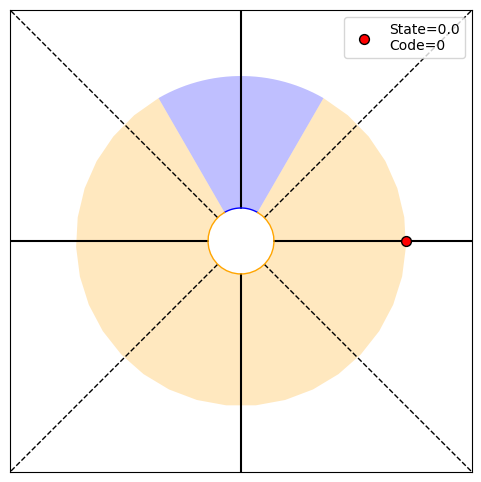

PRINT 1: nan, [0. 0. 0. 0.]
PRINT 2: [nan nan], [nan nan]
[nan nan], Step to take: -1.5707963267948966, Next angle: -450.0


/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_26691/4156093078.py:27: RuntimeWarning: invalid value encountered in scalar divide
  likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target / joint_prob_received_obs_state_t[time_ind-1].sum()
/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_26691/4156093078.py:41: RuntimeWarning: invalid value encountered in divide
  likelihood_obs_from_target_forecast_t_given_received_obs = likelihood_obs_from_target_forecast_t / likelihood_received_obs_from_target


In [108]:
# while time_ind < max_iter:
if time_ind<1:
    angles_visited[time_ind] = initial_angle
else:
    angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
    code_received_t[time_ind] = 1
else:
    code_received_t[time_ind] = 0
print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
observe_angle_state_pair((angles_visited[time_ind]%360))

if time_ind<1:
    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
else:
    state_transition_matrix = get_state_transition_matrix(step_to_take)
    joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
likelihood_received_obs_from_target = joint_prob_received_obs_state_t[time_ind].sum()

if time_ind<1:
    likelihood_received_obs = np.array([likelihood_received_obs_from_target, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
else:
    likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target / joint_prob_received_obs_state_t[time_ind-1].sum()
    likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

if 1 in posterior_t[time_ind]:
    current_entropyS_t[time_ind] = 0
else:
    current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

for i, forecast_t_candidate_step in enumerate(candidate_steps):
    state_transition_matrix = get_state_transition_matrix(forecast_t_candidate_step)

    joint_prob_obs_state_forecast_t[time_ind] = (joint_prob_received_obs_state_t[time_ind] @ state_transition_matrix) * EMISSION_MATRIX_B
    likelihood_obs_from_target_forecast_t = joint_prob_obs_state_forecast_t[time_ind].sum(axis=1)
    likelihood_obs_from_target_forecast_t_given_received_obs = likelihood_obs_from_target_forecast_t / likelihood_received_obs_from_target

    likelihood_obs0_forecast_t_given_received_obs = np.array([likelihood_obs_from_target_forecast_t_given_received_obs[0], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_forecast_given_received_obs0 = (posterior_t[time_ind] * likelihood_obs0_forecast_t_given_received_obs) / (posterior_t[time_ind] * likelihood_obs0_forecast_t_given_received_obs).sum()

    likelihood_obs1_forecast_t_given_received_obs = np.array([likelihood_obs_from_target_forecast_t_given_received_obs[1], LIKELIHOOD_OBS_FROM_NONTARGET])
    posterior_forecast_given_received_obs1 = (posterior_t[time_ind] * likelihood_obs1_forecast_t_given_received_obs) / (posterior_t[time_ind] * likelihood_obs1_forecast_t_given_received_obs).sum()
    
    if 1 in posterior_forecast_given_received_obs0:
        forecasted_S0 = 0
    else:
        forecasted_S0 = (-posterior_forecast_given_received_obs0 * np.log2(posterior_forecast_given_received_obs0)).sum()

    if 1 in posterior_forecast_given_received_obs1:
        forecasted_S1 = 0
    else:
        forecasted_S1 = (-posterior_forecast_given_received_obs1 * np.log2(posterior_forecast_given_received_obs1)).sum()

    prob_obs0_at_forecast_t2_given_obs0_at_t1 = (posterior_t[time_ind] * np.array([likelihood_obs_from_target_forecast_t_given_received_obs[0], LIKELIHOOD_OBS_FROM_NONTARGET])).sum()
    prob_obs1_at_forecast_t2_given_obs0_at_t1 = (posterior_t[time_ind] * np.array([likelihood_obs_from_target_forecast_t_given_received_obs[1], LIKELIHOOD_OBS_FROM_NONTARGET])).sum()

    expected_forecast_t_S = (forecasted_S0 * prob_obs0_at_forecast_t2_given_obs0_at_t1) + (forecasted_S1 * prob_obs1_at_forecast_t2_given_obs0_at_t1)
    expected_forecast_t_S_per_step[time_ind, i] = expected_forecast_t_S

deltaS_t[time_ind] = current_entropyS_t[time_ind] - expected_forecast_t_S_per_step[time_ind]
print(f'PRINT 1: {current_entropyS_t[time_ind]}, {joint_prob_received_obs_state_t[time_ind]}')
print(f'PRINT 2: {deltaS_t[time_ind]}, {posterior_t[time_ind]}')

step_to_take = candidate_steps[deltaS_t[time_ind].argmax()]
print(f'{deltaS_t[time_ind] - (deltaS_t[time_ind].max())}, Step to take: {step_to_take}, Next angle: {angles_visited[time_ind] + np.rad2deg(step_to_take)}')

time_ind+=1

In [109]:
code_received_t[:time_ind]

array([0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [110]:
inds_where_zeros = np.where(code_received_t[:time_ind]==0)[0]
inds_where_change_in_zero = (inds_where_zeros[:-1] - inds_where_zeros[1:]) < -1
zeros_after_ones = inds_where_zeros[1:][inds_where_change_in_zero] + 1
zeros_before_ones = inds_where_zeros[:-1][inds_where_change_in_zero] + 1
zeros_before_ones, zeros_after_ones

(array([7]), array([9]))

In [111]:
inds_where_zeros

array([0, 1, 2, 3, 4, 5, 6, 8])

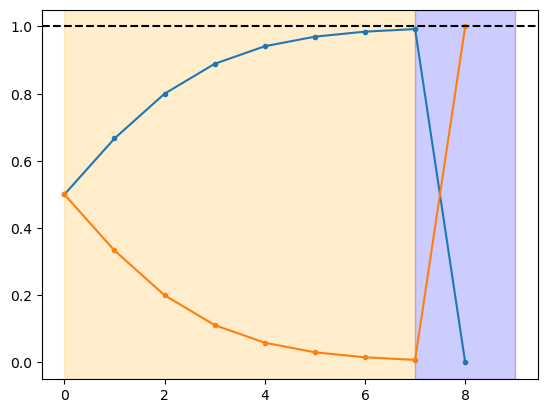

In [113]:
plt.plot(np.vstack([PRIOR_TARGET_PROB, posterior_t[:time_ind]]), marker='.')
plt.axvspan(0, zeros_before_ones[0], alpha=0.2, zorder=1, color='orange')
for i in range(zeros_before_ones.shape[0]-1):
    plt.axvspan(zeros_after_ones[i], zeros_before_ones[i+1], alpha=0.2, zorder=1, color='orange')
    plt.axvspan(zeros_before_ones[i], zeros_after_ones[i], alpha=0.2, zorder=1, color='blue')
plt.axvspan(zeros_after_ones[-1], time_ind, alpha=0.2, zorder=1, color='orange')
plt.axvspan(zeros_before_ones[-1], zeros_after_ones[-1], alpha=0.2, zorder=1, color='blue')
plt.axhline(y=1.0, linestyle='dashed', color='k')
plt.show()

In [164]:
po0 = np.array([3/5, 2/5])
po1 = np.array([1/3, 2/3])

time1_entropy = ((-1 * np.sum(po0 * np.log2(po0))) + (-1 * np.sum(po1 * np.log2(po1)))) / 2
time1_entropy

np.float64(0.9446232142545791)

In [165]:
(-1 * np.sum(po0 * np.log2(po0)))

np.float64(0.9709505944546686)

In [166]:
(-1 * np.sum(po1 * np.log2(po1)))

np.float64(0.9182958340544896)

In [167]:
po0 = np.array([3/5, 2/5])
po1 = np.array([1/3, 2/3])

((-1 * np.sum(po0 * np.log2(po0))) + (-1 * np.sum(po1 * np.log2(po1)))) / 2

np.float64(0.9446232142545791)

In [ ]:
((-1 * np.sum(po0 * np.log2(po0))) * (5/8)) + ((-1 * np.sum(po1 * np.log2(po1))) * (3/8))

np.float64(0.9512050593046015)

In [173]:
po0o0 = np.array([2/3, 1/3])
po0o1 = np.array([1/2, 1/2])
po1o0 = np.array([1/2, 1/2])
po1o1 = np.array([1e-120, 1 - 1e-120])

with_mem_avg_entropy = ((-1 * np.sum(po0o0 * np.log2(po0o0))) + (-1 * np.sum(po0o1 * np.log2(po0o1))) + (-1 * np.sum(po1o0 * np.log2(po1o0))) + (-1 * np.sum(po1o1 * np.log2(po1o1)))) / 4
with_mem_avg_entropy

np.float64(0.7295739585136224)

In [175]:
((-1 * np.sum(po0o0 * np.log2(po0o0))) * (3/8)) + (1/2)

np.float64(0.8443609377704335)

In [136]:
(-1 * np.sum(po0o0 * np.log2(po0o0)))

np.float64(0.9182958340544896)

In [137]:
(-1 * np.sum(po0o1 * np.log2(po0o1)))

np.float64(1.0)

In [138]:
(-1 * np.sum(po1o1 * np.log2(po1o1)))

np.float64(3.986313713864835e-118)

In [177]:
po0o0 = np.array([9/13, 4/13])
po0o1 = np.array([3/7, 4/7])
po1o0 = np.array([3/7, 4/7])
po1o1 = np.array([1/5, 4/5])

without_mem_avg_entropy = ((-1 * np.sum(po0o0 * np.log2(po0o0))) + (-1 * np.sum(po0o1 * np.log2(po0o1))) + (-1 * np.sum(po1o0 * np.log2(po1o0))) + (-1 * np.sum(po1o1 * np.log2(po1o1)))) / 4
without_mem_avg_entropy

np.float64(0.8957190017938392)

In [179]:
(-1 * np.sum(po0o0 * np.log2(po0o0)))

np.float64(0.8904916402194913)

In [180]:
(-1 * np.sum(po0o1 * np.log2(po0o1)))

np.float64(0.9852281360342515)

In [181]:
(-1 * np.sum(po1o1 * np.log2(po1o1)))

np.float64(0.7219280948873623)

In [184]:
(((-1 * np.sum(po0 * np.log2(po0))) * (5/8)) + ((-1 * np.sum(po1 * np.log2(po1))) * (3/8))) - (((5/32)*(-1 * np.sum(po1o1 * np.log2(po1o1)))) + ((7/32)*(-1 * np.sum(po0o1 * np.log2(po0o1)))) + ((7/32)*(-1 * np.sum(po0o1 * np.log2(po0o1)))) + ((13/32)*(-1 * np.sum(po0o0 * np.log2(po0o0)))))

np.float64(0.04560425612429775)

In [182]:
((5/32)*(-1 * np.sum(po1o1 * np.log2(po1o1)))) + ((7/32)*(-1 * np.sum(po0o1 * np.log2(po0o1)))) + ((7/32)*(-1 * np.sum(po0o1 * np.log2(po0o1)))) + ((13/32)*(-1 * np.sum(po0o0 * np.log2(po0o0))))

np.float64(0.9056008031803038)

In [160]:
time1_entropy

np.float64(0.9446232142545791)

In [161]:
with_mem_avg_entropy

np.float64(0.7295739585136224)

In [162]:
without_mem_avg_entropy

np.float64(0.8957190017938392)

In [ ]:
time1_entropy - with_mem_avg_entropy

np.float64(0.21504925574095668)

In [155]:
time1_entropy - without_mem_avg_entropy

np.float64(0.04890421246073984)